<a href="https://colab.research.google.com/github/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Armanda Lewis (al861@nyu.edu)

Fall 2024 - Deep Learning

CS-GY 6953 / ECE-GY 7123

Professor Sandoval


#####Notebook 3: playing with multimodal model. I want to see if I can boost performance with multimodality


In [1]:
# Install Pytorch
!pip install "torch==2.2.2" tensorboard
# Install Hugging Face libraries
!pip install  --upgrade "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"

!pip install --upgrade transformers
!pip install --upgrade vllm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

I used the lab notebook on finetuning LLMs as a starting point, and made sure to use Lora for fast(er) finetuning.  


#### **Fine-tuning for sequential classification - inclusion**

First, I need the data, and I mention in my report the prework that was done.  I consulted https://huggingface.co/docs/transformers/main/en/model_doc/llama for some of the transformer code.



##### **Use huggingface to import llama 3.2-8B model**




In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `f24dl` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `f24dl`


##### Import necessary libraries

In [2]:
import os
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


#### **Load my data - I mapped this to my "belonging" aspect for inclusion**


In [3]:
df = pd.read_csv("dial_classification4.csv")
df

,instruction,summary,label,target
0,Categorize the dialogue snippet into one of th...,"Okay we need to select three , an vowel a cons...",Solution,5
1,Categorize the dialogue snippet into one of th...,you would also need to check the because if i...,Reasoning,4
2,Categorize the dialogue snippet into one of th...,Specifically to test the rule it seems to me...,Solution,5
3,Categorize the dialogue snippet into one of th...,"Yeah , since it didn''t say an even number has...",Reasoning,4
4,Categorize the dialogue snippet into one of th...,me too,Agree,0
...,...,...,...,...
8557,Categorize the dialogue snippet into one of th...,'because it doesn''t say that only vowels can ...,Reasoning,4
8558,Categorize the dialogue snippet into one of th...,'Even numbers don''t have to have vowels on th...,Reasoning,4
8559,Categorize the dialogue snippet into one of th...,think it is wrong but what the heck,Disagree,1
8560,Categorize the dialogue snippet into one of th...,"I agree , I think and are the only onese we ...",Agree,0


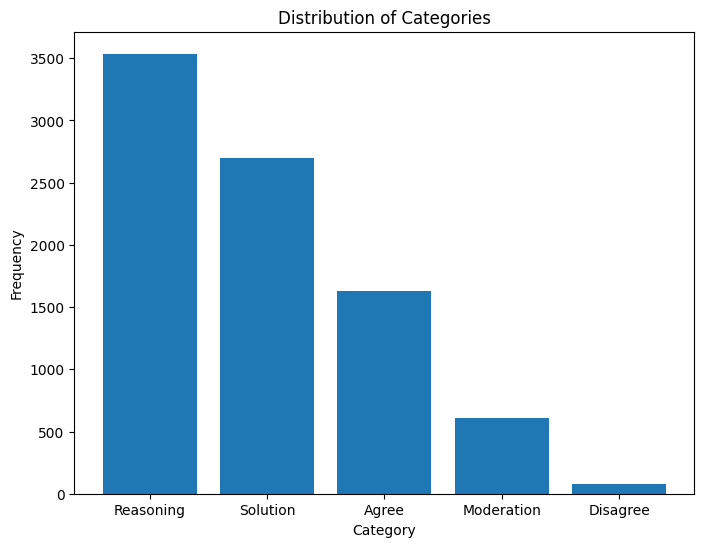

In [4]:
# @title Distribution of Categories

import matplotlib.pyplot as plt

# Assuming your dataframe is named 'df'
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Category')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Categories')


####Convert my target column into a category type for later

In [5]:
df['label']=df['label'].astype('category')
df['target']=df['label'].cat.codes

df.head()

,instruction,summary,label,target
0,Categorize the dialogue snippet into one of th...,"Okay we need to select three , an vowel a cons...",Solution,4
1,Categorize the dialogue snippet into one of th...,you would also need to check the because if i...,Reasoning,3
2,Categorize the dialogue snippet into one of th...,Specifically to test the rule it seems to me...,Solution,4
3,Categorize the dialogue snippet into one of th...,"Yeah , since it didn''t say an even number has...",Reasoning,3
4,Categorize the dialogue snippet into one of th...,me too,Agree,0


In [6]:
df['label'].cat.categories

Index(['Agree', 'Disagree', 'Moderation', 'Reasoning', 'Solution'], dtype='object')

In [7]:
category_map = {code: category for code, category in enumerate(df['label'].cat.categories)}
category_map
num_cats = len(category_map)
num_cats #will need this later when I specify my model task

5

#### Split into splits (train: 60%; validation: 20%; test: 20%)

I do have uneven classes, which I will try to tweak on a second pass.

In [8]:
train_end_point = int(df.shape[0]*0.6)
val_end_point = int(df.shape[0]*0.8)
df_train = df.iloc[:train_end_point,:]
df_val = df.iloc[train_end_point:val_end_point,:]
df_test = df.iloc[val_end_point:,:]
print(df_train.shape, df_test.shape, df_val.shape)



(5137, 4) (1713, 4) (1712, 4)


#### Convert from Pandas DataFrame to Hugging Face Dataset for dictionary format that HF likes



In [9]:
# Converting pandas DataFrames into Hugging Face Dataset objects:
dataset_train = Dataset.from_pandas(df_train.drop('label',axis=1))
dataset_val = Dataset.from_pandas(df_val.drop('label',axis=1))
dataset_test = Dataset.from_pandas(df_test.drop('label',axis=1))


In [10]:
# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=42)  # Using a seed for reproducibility


In [11]:
# Combine them into a single DatasetDict
dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val,
    'test': dataset_test
})
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'summary', 'target'],
        num_rows: 5137
    })
    val: Dataset({
        features: ['instruction', 'summary', 'target'],
        num_rows: 1712
    })
    test: Dataset({
        features: ['instruction', 'summary', 'target'],
        num_rows: 1713
    })
})

In [12]:
dataset['train']

Dataset({
    features: ['instruction', 'summary', 'target'],
    num_rows: 5137
})

* Since our classes are not balanced let's calculate class weights based on inverse value counts
* Convert to pytorch tensor since we will need it

In [13]:
df_train.target.value_counts(normalize=True)

,proportion
target,
3,0.419506
4,0.310687
0,0.189605
2,0.069885
1,0.010317


In [14]:
class_weights=(1/df_train.target.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights


tensor([0.0432, 0.7937, 0.1172, 0.0195, 0.0264])

#### **Load and customize llama for training**

I consulted the lab notebooks for this!

In [15]:
model_name = "meta-llama/Llama-3.2-1B"

#### Quantization Config (for QLORA)

In [16]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)


#### Lora Config

In [17]:
lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

#### Load model
As I mention in the report, I am doing a sequential classification task for multiclass prediction.

In [18]:

#
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    num_labels=num_cats
)

model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

* prepare_model_for_kbit_training() function to preprocess the quantized model for training (see lab notes)

In [19]:
model = prepare_model_for_kbit_training(model)
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

prepares a model for training with LoRA (also see lab notes)

In [20]:
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
        

#### Load the tokenizer

As mentioned in lab, be sure to add EOS token or training will go on forever!

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

#### Update some model configs
* Must use .cache = False as below or it crashes from my experience

In [22]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

#### Trial run to see output

In [23]:
blurbs = df_test.summary.tolist()
blurbs[0:2]

['Yes we all said the letter  is one of the cards to flip',
 'we dont care about  , it could be any letter']

In [24]:
# Convert summaries to a list
blurbs = df_test.summary.tolist()

# Define the batch size
batch_size = 32  # You can adjust this based on your system's memory capacity

# Initialize an empty list to store the model outputs
all_outputs = []

# Process the sentences in batches
for i in range(0, len(blurbs), batch_size):
    # Get the batch
    batch_blurbs = blurbs[i:i + batch_size]

# Ensure all elements in batch_blurbs are strings
#I kept getting this error, and it ened up being that I was passing some text that was not
#encoded as string, so I am forcing that in this step
    batch_blurbs = [str(blurb) for blurb in batch_blurbs]  # Convert to string if not already

    # Tokenize the batch
    inputs = tokenizer(batch_blurbs, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move tensors to the device where the model is (e.g., GPU or CPU)
    inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

    # Perform inference and store the logits
    with torch.no_grad():
        outputs = model(**inputs)
        all_outputs.append(outputs['logits'])



#### Get single tensor

In [25]:
final_outputs = torch.cat(all_outputs, dim=0)
final_outputs

tensor([[-0.3562, -1.9807,  1.9517, -0.6266,  1.4467],
        [ 0.8655, -2.0964,  1.8503,  0.3730,  2.5651],
        [-1.1950, -1.0912,  1.8409,  1.1187,  1.0147],
        ...,
        [ 0.5926, -2.8567,  2.3809,  1.3357,  0.1554],
        [ 0.4009, -2.1268,  1.5858,  1.9971,  2.1123],
        [-0.4699, -0.1896,  5.4452,  1.2349,  3.0554]], device='cuda:0')

* argmax to get class prediction

In [26]:
final_outputs.argmax(axis=1)

tensor([2, 4, 2,  ..., 2, 4, 2], device='cuda:0')

#### Get some predictions

In [27]:
df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
df_test['predictions']

<ipython-input-27-7c1d2547ae19>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()


,predictions
6849,2
6850,4
6851,2
6852,2
6853,4
...,...
8557,2
8558,2
8559,2
8560,4


In [28]:
df_test['predictions'].value_counts()

,count
predictions,
2,919
4,363
3,332
0,98
1,1


#### Use category map to get back category names

In [29]:
df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])
df_test['predictions']

<ipython-input-29-b56fb9d5a919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


,predictions
6849,Moderation
6850,Solution
6851,Moderation
6852,Moderation
6853,Solution
...,...
8557,Moderation
8558,Moderation
8559,Moderation
8560,Solution


#### Analyze performance with matrix

In [30]:
def get_performance_metrics(df_test):
  y_test = df_test.label
  y_pred = df_test.predictions

  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

  print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))
  print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [31]:
get_performance_metrics(df_test)

Confusion Matrix:
[[ 12   0 231  27  25]
 [  1   0  11   4   2]
 [  3   0  80  38  14]
 [ 28   1 356 135 197]
 [ 54   0 241 128 125]]

Classification Report:
              precision    recall  f1-score   support

       Agree       0.12      0.04      0.06       295
    Disagree       0.00      0.00      0.00        18
  Moderation       0.09      0.59      0.15       135
   Reasoning       0.41      0.19      0.26       717
    Solution       0.34      0.23      0.27       548

    accuracy                           0.21      1713
   macro avg       0.19      0.21      0.15      1713
weighted avg       0.31      0.21      0.22      1713

Balanced Accuracy Score: 0.20993145346075223
Accuracy Score: 0.20548744892002335


# Trainer Components
* model
* tokenizer
* training arguments
* train dataset
* eval dataset
* Data Collater
* Compute Metrics
* class_weights: In our case since we are using a custom trainer so we can use a weighted loss we will subclass trainer and define the custom loss.

#### Get ready for llama finetuning

In [32]:
MAX_LEN = 512
col_to_delete = ['instruction', 'summary']

def llama_preprocessing_function(examples):
    examples['summary'] = [str(sentence) for sentence in examples['summary']]

    return tokenizer(examples['summary'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(llama_preprocessing_function, batched=True, remove_columns=col_to_delete)
tokenized_datasets = tokenized_datasets.rename_column("target", "label")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/5137 [00:00<?, ? examples/s]

Map:   0%|          | 0/1712 [00:00<?, ? examples/s]

Map:   0%|          | 0/1713 [00:00<?, ? examples/s]

## Data Collator - gotten from Hugging face base code
A **data collator** prepares batches of data for training or inference in ML/DL.

In [33]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)


#### specify eval metrics (accuracy)

In [34]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'balanced_accuracy' : balanced_accuracy_score(predictions, labels),'accuracy':accuracy_score(predictions,labels)}



#### Define custom trainer with classweights
* We will have a custom loss function that deals with the class weights --> my classes are imbalanced, so this is important

In [40]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels and convert them to long type for cross_entropy
        labels = inputs.pop("labels").long()

        # Forward pass
        outputs = model(**inputs)

        # Extract logits assuming they are directly outputted by the model
        logits = outputs.get('logits')

        # Compute custom loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss


#### define training args

#### Set args and trainer hyperparameters

In [46]:
training_args = TrainingArguments(
        output_dir = 'inclusive_classification3',
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        max_steps =200,
        learning_rate = 1e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 1492,
        report_to = "wandb", # Use this for WandB etc
    )

In [47]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

<ipython-input-40-01b30de6202e>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
<ipython-input-40-01b30de6202e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)


#### Let's train
Cite:  https://huggingface.co/docs/transformers/en/training

In [48]:
train_result = trainer.train()
#I am using wandb for tracking

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,3.466700
2,3.129100
3,2.714200
4,3.540900
5,4.467300
6,2.359200
7,2.739800
8,4.151300
9,3.880000
10,3.682200


In [49]:
average_training_loss = train_result.training_loss
print(f"Average Training Loss: {average_training_loss}")

Average Training Loss: 3.0827865670621395


In [50]:
# Accessing the training log history
log_history = trainer.state.log_history

# Extract loss values
losses = [entry['loss'] for entry in log_history if 'loss' in entry]
steps = list(range(1, len(losses) + 1))

# Print loss data
#print(losses)

In [51]:
losses_df_llama3_2 = pd.DataFrame({
    "Losses": losses,
    "Steps": steps
})

losses_df_llama3_2.to_csv("losses_df_llama3_2.csv", index=False)
print("Submission file saved as 'losses_df_llama3_2.csv")

Submission file saved as 'losses_df_llama3_2.csv


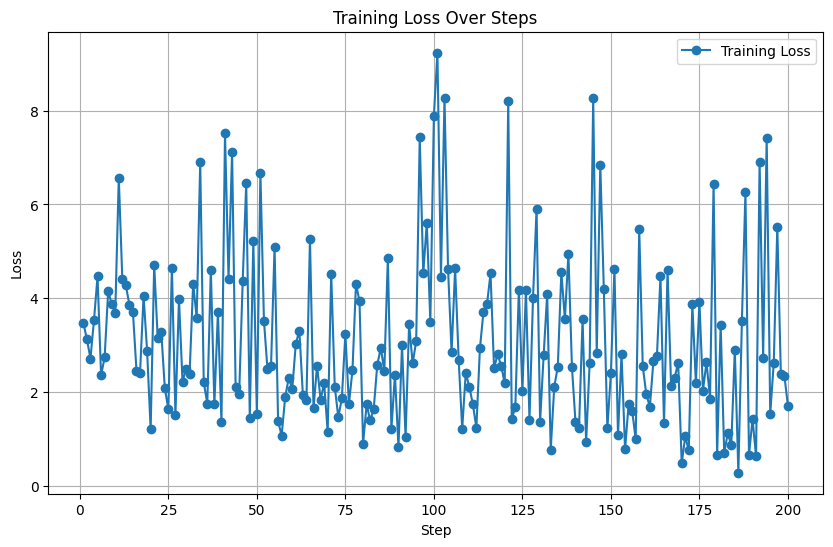

In [52]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.grid()
plt.show()

#### Let's check the results
* I wrapped in a function

In [53]:
def make_predictions(model,df_test):


  # Convert summaries to a list
  sentences = df_test.summary.tolist()

  # Define the batch size
  batch_size = 32  # You can adjust this based on your system's memory capacity

  # Initialize an empty list to store the model outputs
  all_outputs = []

  # Process the blurbs in batches
  for i in range(0, len(blurbs), batch_size):
      # Get the batch of blurbs
      batch_blurbs = blurbs[i:i + batch_size]

# Ensure all elements in batch_blurbs are strings THIS WAS WHAT I WAS MISSING!
      batch_blurbs = [str(blurb) for blurb in batch_blurbs]  # Convert to string if not already

      # Tokenize the batch
      inputs = tokenizer(batch_blurbs, return_tensors="pt", padding=True, truncation=True, max_length=512)

      # Move tensors to the device where the model is (e.g., GPU or CPU)
      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}

      # Perform inference and store the logits
      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])
  final_outputs = torch.cat(all_outputs, dim=0)
  df_test['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  df_test['predictions']=df_test['predictions'].apply(lambda l:category_map[l])


make_predictions(model,df_test)

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
<ipython-input-53-5a23d93d75b2>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions']=final_outpu

In [54]:
get_performance_metrics(df_test)

Confusion Matrix:
[[268   0   2  11  14]
 [  9   0   0   8   1]
 [  9   0 108   8  10]
 [ 19   0  21 593  84]
 [ 34   0  23 135 356]]

Classification Report:
              precision    recall  f1-score   support

       Agree       0.79      0.91      0.85       295
    Disagree       0.00      0.00      0.00        18
  Moderation       0.70      0.80      0.75       135
   Reasoning       0.79      0.83      0.81       717
    Solution       0.77      0.65      0.70       548

    accuracy                           0.77      1713
   macro avg       0.61      0.64      0.62      1713
weighted avg       0.77      0.77      0.77      1713

Balanced Accuracy Score: 0.6370333590946511
Accuracy Score: 0.7734967892586107


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Saving the model trainer state and model adapters

In [55]:
metrics = train_result.metrics
max_train_samples = len(dataset_train)
metrics["train_samples"] = min(max_train_samples, len(dataset_train))
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =     0.3114
  total_flos               =   153648GF
  train_loss               =     3.0828
  train_runtime            = 0:03:12.95
  train_samples            =       5137
  train_samples_per_second =      8.292
  train_steps_per_second   =      1.037


#### Saving finetuned model and post to HF

In [56]:
trainer.save_model("saved_model3_llama_3_2_8b")
new_model = "armanda/dial-classification-3-llama-3-2-8b"

In [57]:
# Push fine-tuned model and tokenizer to Hugging Face Hub
model.push_to_hub(new_model, use_auth_token = True)
tokenizer.push_to_hub(new_model, use_auth_token = True)



/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:894: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/armanda/dial-classification-3-llama-3-2-8b/commit/b1c05d2965a4e8a12f127a3e9a5ba088706f1323', commit_message='Upload tokenizer', commit_description='', oid='b1c05d2965a4e8a12f127a3e9a5ba088706f1323', pr_url=None, repo_url=RepoUrl('https://huggingface.co/armanda/dial-classification-3-llama-3-2-8b', endpoint='https://huggingface.co', repo_type='model', repo_id='armanda/dial-classification-3-llama-3-2-8b'), pr_revision=None, pr_num=None)